### The Impulse Response and Convolution

In this notebook, we will make a crude impulse response measurement and use it to do a convolution.

In [2]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook

### A crude impulse response measurement

Let's take the room that we are in as an example of a system. We can imagine an input signal to tbe the speech that you produce and the output signal to be the resulting sound at any point within the room, including that of your own ears. In between the input and output, we essentially have the room itself which acts as a system. Hence your voice will be modified or filtered by the room before it arrives to any point within the room. It is the acoustic properties of the room (such as how absorptive/reflective materials are in the room) that determine the impulse response of the classroom system. You can think of how other rooms affect any input sound - a church, a concert hall, etc. All of these systems can be quantitatively described by their acoustic impulse responses, which is in fact one of the most important pieces of information for doing audio signal processing in general. 

So let's attempt to make a crude measurement of the impulse response of the room that we are in. We can approximate an impulse signal by one which has a high amplitude and short duration. This is why you may sometimes see people clapping inside rooms to get an idea of their impulse response. But let's do something a bit more fun. We can pop a balloon to generate our impulse! Let's try that and see if we can sufficiently excite the room. What is the resulting system order?

In [3]:
# Recording the impulse response - pop the balloon or clap your hand immediately after running this cell.
duration = 6  # seconds
fs = 8000    # Sampling frequency (Hz)
print ('recording...')
IR = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')



recording...
finished recording


Data shape:  (48000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


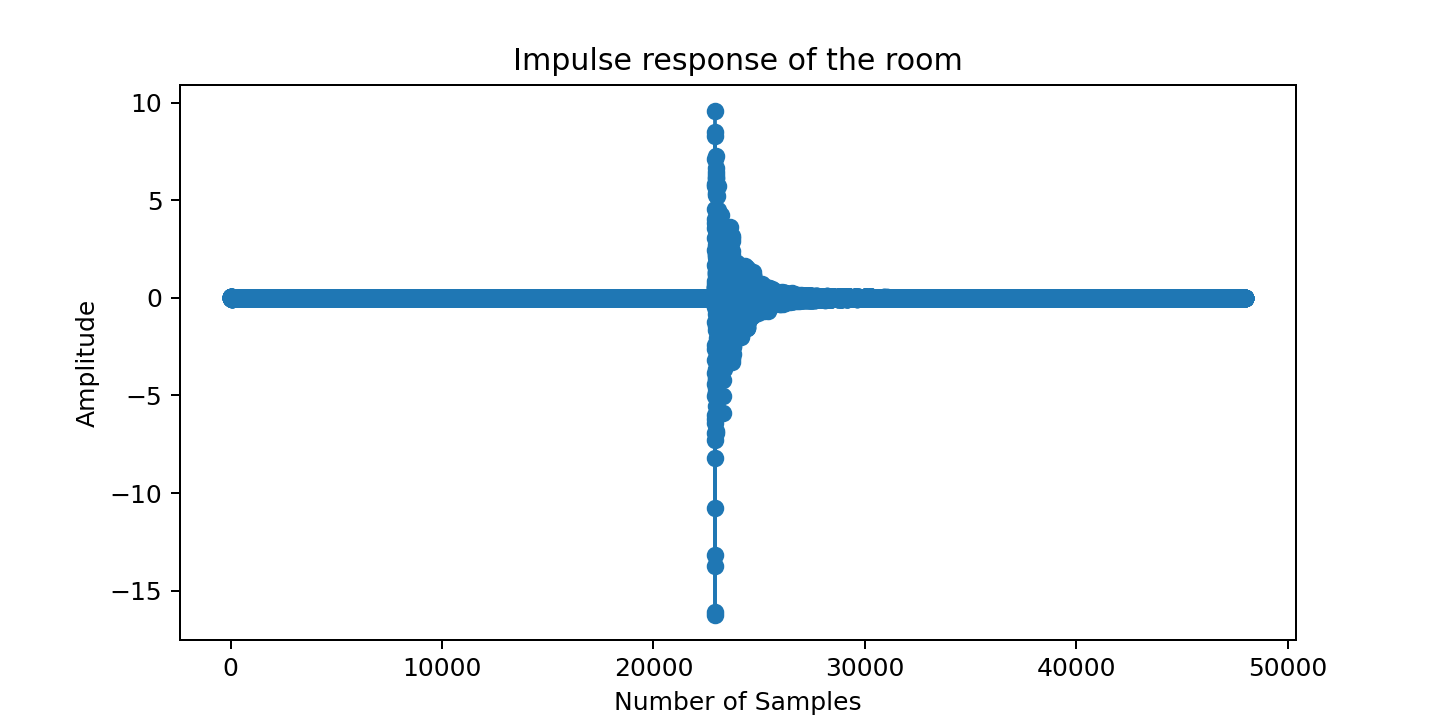

Text(0, 0.5, 'Amplitude')

In [15]:
print("Data shape: ", IR.shape)
print("Recorded Signal:")
IPython.display.display(Audio(IR.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

# axes.plot(IR)
axes.stem(IR,basefmt=" ")
axes.set_title('Impulse response of the room')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


Okay great, now that we have our crude impulse response of the room, we can proceed to do a **convolution** with another signal. Let's reflect for a moment on this. The impulse response we measured was between 2 physical locations, i.e. from the point where the balloon was popped to the point of the microphone on the computer. This does not mean that this one impulse response has characterised the entire room, but only the transfer function between these two positions. In fact if we were to make the measurement for any other two locations in the room, the impulse response that we obtain would be different, and this is one of the reasons why acoustic signal processing can be quite challenging. At any rate, what we essentially have is an impulse response for two specific locations, so if we wanted to simulate how an input audio signal (speech or music signal for instance) would sound at the point of the microphone when generated from the location of the balloon pop, all we need to do now is a convolution between our input audio signal and the impulse response.

There is another subtle detail worth highlighting here, but one that we will not pay too much attention to for now. The impulse response that we have measured here includes effects from not only the  room, but also the microphone and the data acquisition system within the laptop. Hence we can think of the system as being two blocks, one which is the room and the other the microphone and data acquisition system. If the frequency response of the microphone and data acquisition system is flat, i.e. equal at all frequencies, then we can safely ignore them.

But let's do the convolution and see how things sound!


The sampling frequency of the speech signal is 8000 Hz


<IPython.core.display.Javascript object>


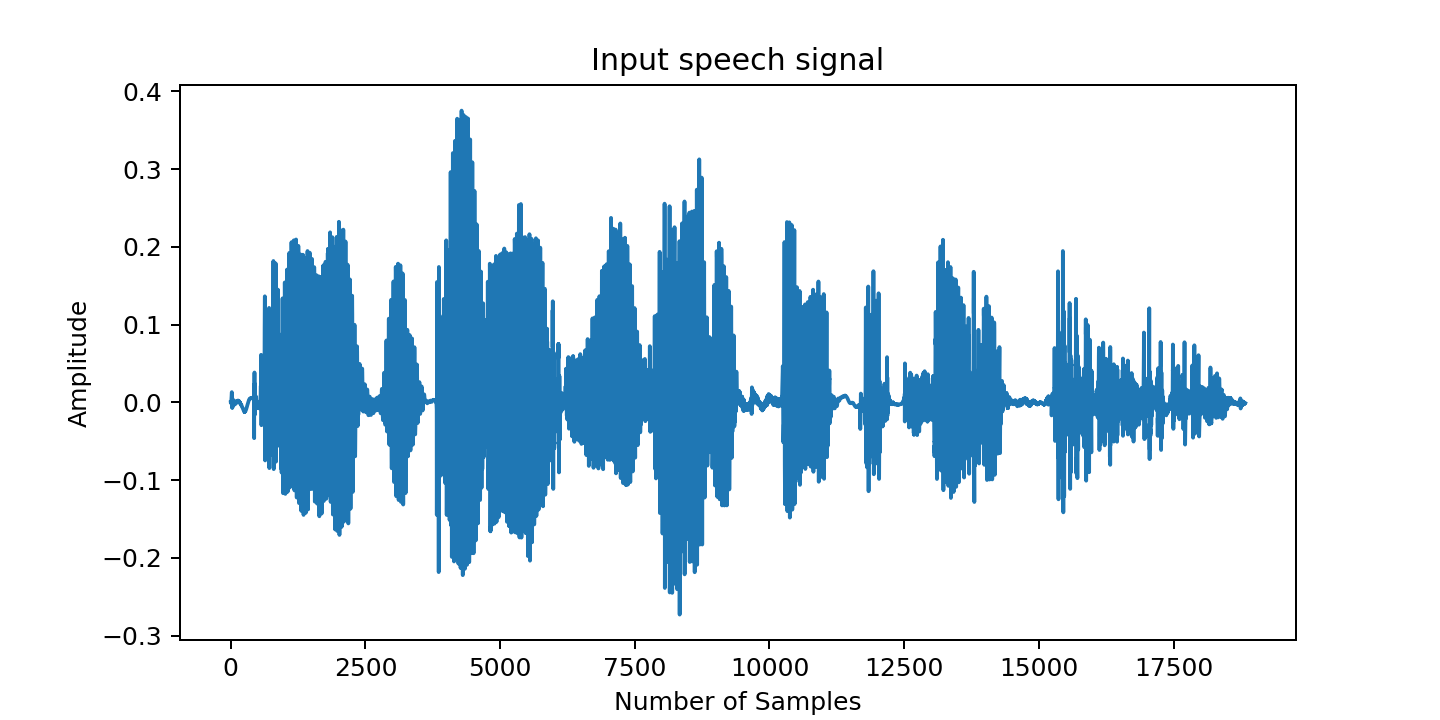

Text(0, 0.5, 'Amplitude')

In [16]:
# Read in a speech signal - use the soundfile package for this

speech, fs = sf.read('speech_signal.wav')
print('The sampling frequency of the speech signal is ' + str(fs)+' Hz')

IPython.display.display(Audio(speech.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

axes.plot(speech)
axes.set_title('Input speech signal')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')



Okay we have our speech signal. We will do the convolution by setting up a convolution matrix and doing a matrix-vector product to obtain the convolved signal. You can already see that this is pretty slow and inefficient by observing the sparsity of the convolution matirx (i.e. large number of zero elements). 

<IPython.core.display.Javascript object>


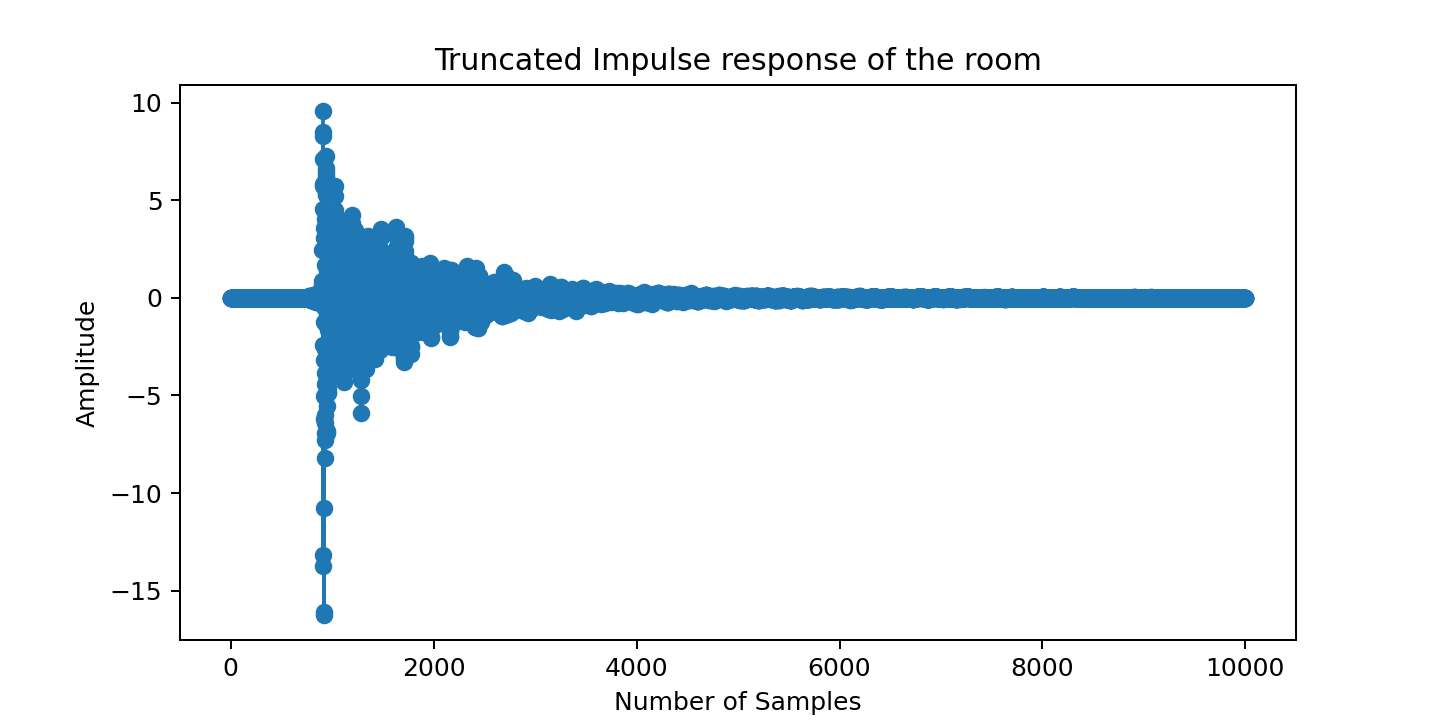

System Order, M = 9999
Length of impulse response, M+1 = 10000
Length of speech signal, L = 18833


<IPython.core.display.Javascript object>


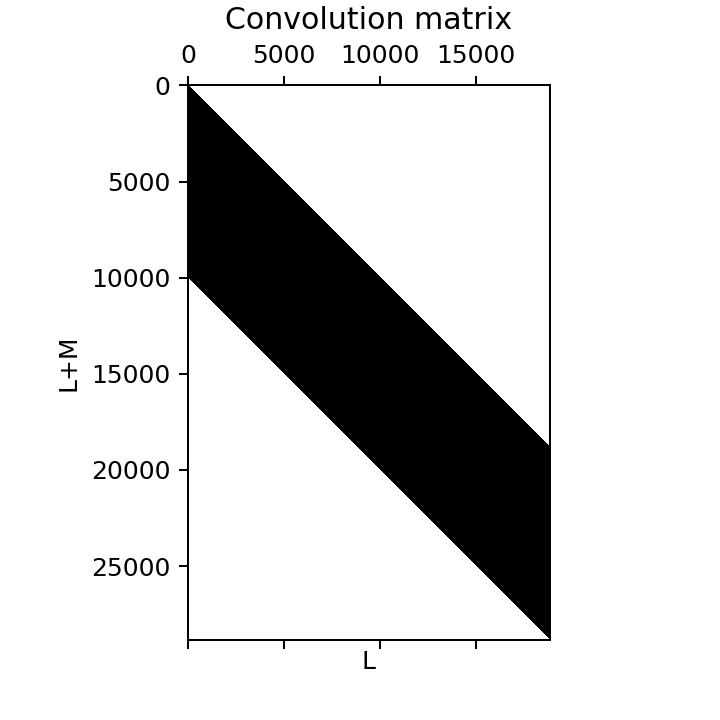

<IPython.core.display.Javascript object>


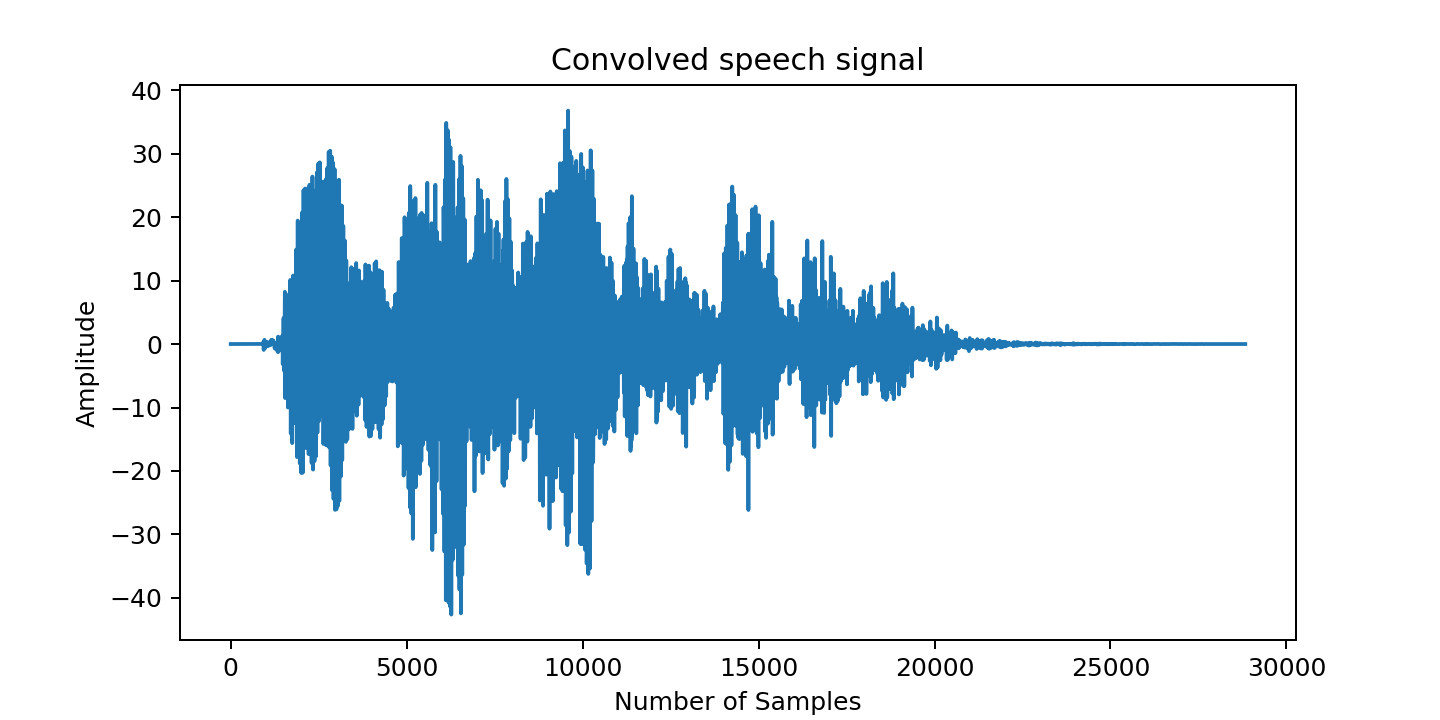

Text(0, 0.5, 'Amplitude')

In [17]:
# Truncate the IR (to remove initial delay and so this does not take forever...)
h = IR[22000:32000,0]

IPython.display.display(Audio(h.T, rate=fs))
fig, axes = plt.subplots(figsize=(8, 4)) 
axes.stem(h,basefmt=" ")
axes.set_title('Truncated Impulse response of the room')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')

M = len(h)-1
L = len(speech)
print('System Order, M = ' + str(M))
print('Length of impulse response, M+1 = ' + str(M+1))
print('Length of speech signal, L = ' +str(L))

# Create the convolution matrix
# Do this by creating a toeplitz matrix 

row1 = np.r_[h[0], np.zeros(L-1)]  # first row in toeplitz matrix
col1 = np.r_[h,np.zeros(L-1)] # first column in toeplitz matrix
H = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix

fig, axes = plt.subplots(figsize=(4, 4)) 

axes.spy(H) # spy plots a sparse matrix - dark colours when there is data, white when none.
axes.set_title('Convolution matrix')
axes.set_xlabel('L')
axes.set_ylabel('L+M')

# Now we can do the matrix multiplication for the convolution

speech_conv = H@speech

IPython.display.display(Audio(speech_conv.T, rate=fs))

fig, axes = plt.subplots(figsize=(8, 4)) 

axes.plot(speech_conv)
axes.set_title('Convolved speech signal')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


The convolved speech signal clearly sounds much different than the original signal! We have essentially captured a some sense of how the room 'sounds' as we can convolve any other input signal with our measured impulse response to have an impression of what that signal might sound like within the room.  